In [ ]:
k wepip install torch torchvision torch-geometric sentence-transformers pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00


Loaded dataset with 6521 entries.
Encoding text using SentenceTransformer...
Epoch 1/20, Loss: 1.0993
Epoch 2/20, Loss: 1.1113
Epoch 3/20, Loss: 1.0876
Epoch 4/20, Loss: 1.0706
Epoch 5/20, Loss: 1.0699
Epoch 6/20, Loss: 1.0549
Epoch 7/20, Loss: 1.0567
Epoch 8/20, Loss: 1.0477
Epoch 9/20, Loss: 1.0422
Epoch 10/20, Loss: 1.0390
Epoch 11/20, Loss: 1.0312
Epoch 12/20, Loss: 1.0300
Epoch 13/20, Loss: 1.0261
Epoch 14/20, Loss: 1.0248
Epoch 15/20, Loss: 1.0228
Epoch 16/20, Loss: 1.0228
Epoch 17/20, Loss: 1.0200
Epoch 18/20, Loss: 1.0216
Epoch 19/20, Loss: 1.0174
Epoch 20/20, Loss: 1.0170
Model saved to gnn_model.pth
Training complete.
Model loaded from gnn_model.pth


<ipython-input-6-90eb108d177c>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Classification Report:
                    precision    recall  f1-score   support

      Not Relevant       0.86      0.47      0.61      4812
Partially Relevant       0.17      0.32      0.22       812
          Relevant       0.24      0.64      0.35       897

          accuracy                           0.47      6521
         macro avg       0.42      0.48      0.39      6521
      weighted avg       0.69      0.47      0.52      6521



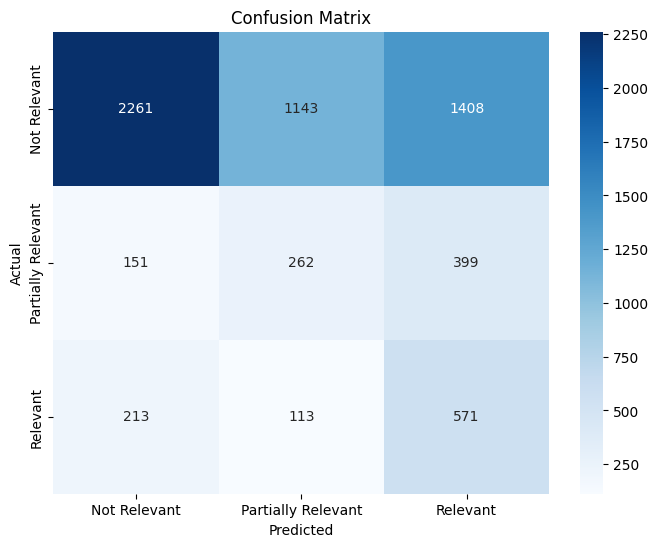

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# --- Step 1: Load and Preprocess Dataset ---
def load_and_preprocess_dataset(file_path):
    df = pd.read_csv(file_path, delimiter=',')
    print(f"Loaded dataset with {len(df)} entries.")

    queries = df['query'].astype(str)
    abstracts = df['abstract'].astype(str)
    labels = df['judgement'].astype(int)

    print("Encoding text using SentenceTransformer...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embeddings = torch.tensor(model.encode(queries), dtype=torch.float)
    abstract_embeddings = torch.tensor(model.encode(abstracts), dtype=torch.float)

    return query_embeddings, abstract_embeddings, torch.tensor(labels, dtype=torch.long)

dataset_path = "/content/cleaned_merged_data.csv"
query_embeddings, abstract_embeddings, labels = load_and_preprocess_dataset(dataset_path)

# --- Step 2: Create Graph Structure ---
def create_graph(query_embeddings, abstract_embeddings, labels):
    num_queries = len(query_embeddings)
    num_abstracts = len(abstract_embeddings)

    # Compute cosine similarity between queries and abstracts
    similarity_matrix = torch.mm(query_embeddings, abstract_embeddings.T)

    # Connect each query to top-k related abstracts
    k = 5
    adj_matrix = torch.zeros((num_queries + num_abstracts, num_queries + num_abstracts))
    for i in range(num_queries):
        top_k_indices = torch.topk(similarity_matrix[i], k=k).indices + num_queries
        adj_matrix[i, top_k_indices] = 1

    # Convert to sparse format
    edge_index, _ = dense_to_sparse(adj_matrix)

    # Combine node features
    node_features = torch.cat([query_embeddings, abstract_embeddings], dim=0)

    # Graph data
    data = Data(x=node_features, edge_index=edge_index, y=labels)
    return data, num_queries

data, num_queries = create_graph(query_embeddings, abstract_embeddings, labels)

# --- Step 3: Define GNN Encoder-Decoder Model ---
class GNNEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNEncoderDecoder, self).__init__()
        self.gnn1 = GCNConv(input_dim, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)
        self.gnn3 = GCNConv(hidden_dim, hidden_dim)
        self.encoder = nn.Linear(hidden_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.gnn1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.gnn2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.gnn3(x, edge_index)
        x = torch.relu(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- Step 4: Train the Model and Save ---
def train_model(model, data, num_queries, epochs=20, lr=0.01, save_path="gnn_model.pth"):
    # Calculate class weights
    class_counts = torch.bincount(data.y)
    class_weights = len(data.y) / (len(class_counts) * class_counts.float())
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)[:num_queries]
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    print("Training complete.")

# --- Step 5: Load the Saved Model ---
def load_saved_model(input_dim, hidden_dim, output_dim, model_path="gnn_model.pth"):
    model = GNNEncoderDecoder(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {model_path}")
    return model

# --- Step 6: Evaluate the Model ---
def evaluate_model(model, data, num_queries):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)[:num_queries]
        predictions = torch.argmax(out, dim=1)
        print("\nClassification Report:")
        print(classification_report(data.y.numpy(), predictions.numpy(), target_names=["Not Relevant", "Partially Relevant", "Relevant"]))

        # Generate confusion matrix
        conf_matrix = confusion_matrix(data.y.numpy(), predictions.numpy())
        plt.figure(figsize=(8, 6))1
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Not Relevant", "Partially Relevant", "Relevant"],
                    yticklabels=["Not Relevant", "Partially Relevant", "Relevant"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

# --- Step 7: Main Workflow ---
input_dim = query_embeddings.size(1)
hidden_dim = 128
output_dim = 3

# Train the model
model = GNNEncoderDecoder(input_dim, hidden_dim, output_dim)
train_model(model, data, num_queries, epochs=20, lr=0.01)

# Load the saved model
saved_model_path = "gnn_model.pth"
loaded_model = load_saved_model(input_dim, hidden_dim, output_dim, saved_model_path)

# Evaluate the loaded model
evaluate_model(loaded_model, data, num_queries)


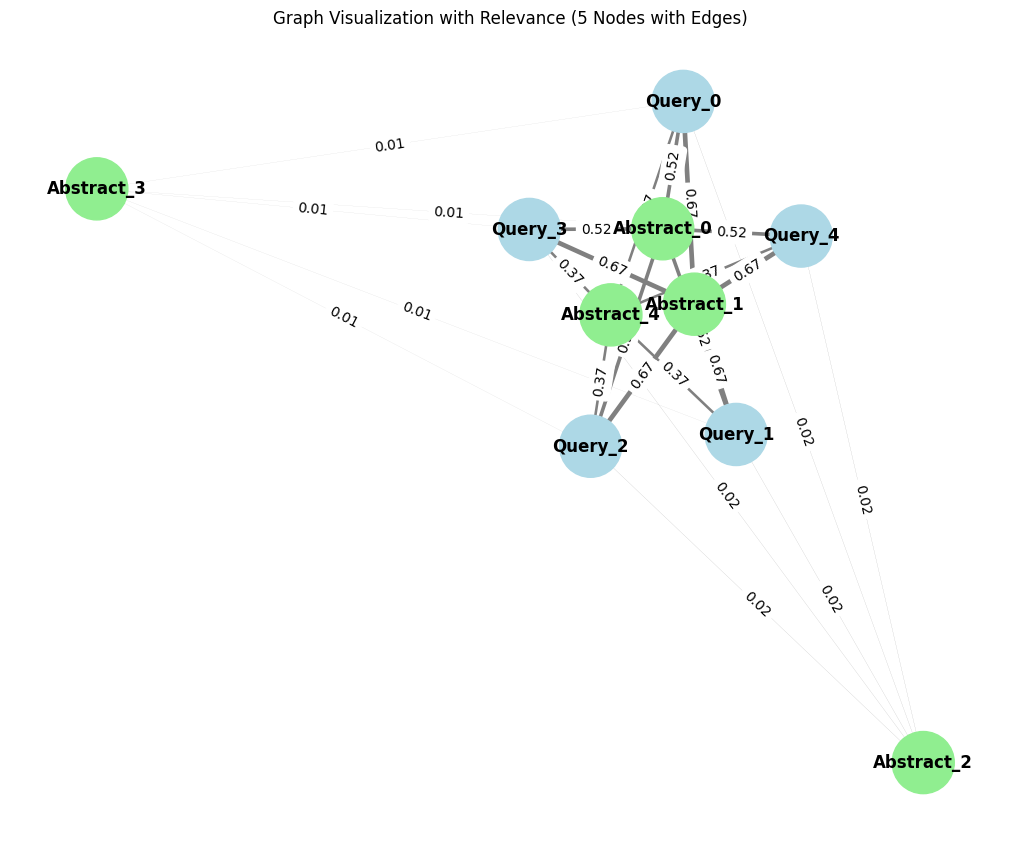

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Create a sample graph with 5 nodes and edges (adjust as necessary)
def generate_and_plot_graph(query_embeddings, abstract_embeddings, k=5):
    # For simplicity, using only the first few nodes (5 nodes in this case)
    num_queries = 5  # You can set this to 5 or any desired number of nodes
    num_abstracts = 5  # Same for abstracts if needed

    # Compute cosine similarity between the query and abstract embeddings
    similarity_matrix = torch.mm(query_embeddings[:num_queries], abstract_embeddings[:num_abstracts].T)

    # Create a graph (using NetworkX)
    G = nx.Graph()

    # Add nodes for queries and abstracts
    for i in range(num_queries):
        G.add_node(f"Query_{i}", type='query')

    for i in range(num_abstracts):
        G.add_node(f"Abstract_{i}", type='abstract')

    # Add edges based on cosine similarity (top-k similar connections)
    for i in range(num_queries):
        top_k_indices = torch.topk(similarity_matrix[i], k).indices
        for idx in top_k_indices:
            relevance = similarity_matrix[i, idx].item()  # Get the relevance score
            G.add_edge(f"Query_{i}", f"Abstract_{idx.item()}", weight=relevance)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes

    # Color nodes based on their type
    node_colors = ['lightblue' if G.nodes[node]['type'] == 'query' else 'lightgreen' for node in G.nodes]

    # Edge width based on relevance (similarity)
    edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # Adjust multiplier for visual effect

    # Draw nodes and edges with adjusted width
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=12, font_weight='bold', edge_color='gray', width=edge_widths)

    # Draw edge labels (relevance score)
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Graph Visualization with Relevance (5 Nodes with Edges)")
    plt.show()

# Example usage (use your actual embeddings here):
generate_and_plot_graph(query_embeddings, abstract_embeddings)


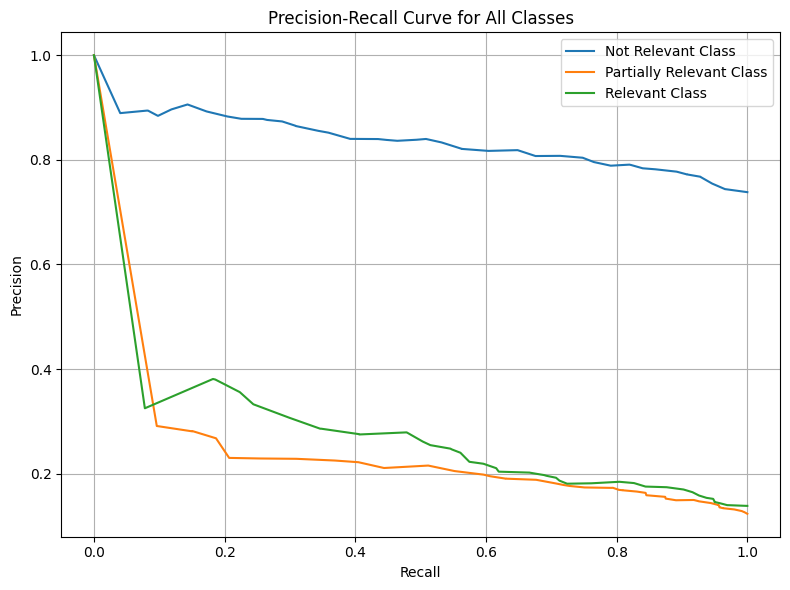

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Function to plot all Precision-Recall Curves in one figure
def plot_combined_precision_recall_curve(model, data, num_queries):
    model.eval()
    with torch.no_grad():
        # Get predictions and probabilities
        out = model(data.x, data.edge_index)[:num_queries]
        probabilities = torch.softmax(out, dim=1).numpy()
        true_labels = data.y.numpy()

        # Initialize the plot
        plt.figure(figsize=(8, 6))

        # For each class, calculate and plot Precision-Recall curve
        for i, class_name in enumerate(["Not Relevant", "Partially Relevant", "Relevant"]):
            precision, recall, _ = precision_recall_curve(true_labels == i, probabilities[:, i])
            plt.plot(recall, precision, label=f"{class_name} Class")

        # Set plot labels and legend
        plt.title("Precision-Recall Curve for All Classes")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.grid()
        plt.tight_layout()
        plt.show()

# Call the function
plot_combined_precision_recall_curve(model, data, num_queries)


In [ ]:
import pandas as pd
import torch

# Mount Google Drive (only if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Path where the file will be saved in Google Drive
google_drive_path = "/content/drive/MyDrive/subset_query_document_results.csv"

df = pd.read_csv(dataset_path, delimiter=',')

def evaluate_and_save_subset(
    model,
    data,
    num_queries,
    query_texts,
    document_texts,
    labels,
    num_docs_per_query=5,
    file_path="subset_results.csv"
):
    model.eval()
    with torch.no_grad():
        # Get predictions for all query nodes
        out = model(data.x, data.edge_index)[:num_queries]
        predictions = torch.argmax(out, dim=1)

        # Collect data for all queries
        query_results = []
        for query_idx in range(num_queries):
            # Find documents connected to this query
            connected_docs = data.edge_index[1, data.edge_index[0] == query_idx].unique()

            # Select up to num_docs_per_query documents
            selected_docs = connected_docs[:num_docs_per_query] if len(connected_docs) >= num_docs_per_query else connected_docs

            for doc_idx in selected_docs:
                query_results.append({
                    "Query": query_texts[query_idx],  # Use original query text
                    "Document": document_texts[doc_idx - num_queries],  # Use original document text
                    "Actual": labels[query_idx].item(),
                    "Predicted": predictions[query_idx].item()
                })

        # Save to Google Drive (or your desired location)
        results_df = pd.DataFrame(query_results)
        results_df.to_csv(google_drive_path, index=False)
        print(f"Subset results saved to {google_drive_path}")

evaluate_and_save_subset(
    model,
    data,
    num_queries,
    query_texts=df['query'].tolist(),  # Original query text from the DataFrame
    document_texts=df['abstract'].tolist(),  # Original document text from the DataFrame
    labels=labels,
    num_docs_per_query=5,
    file_path="subset_query_document_results.csv"
)


Mounted at /content/drive
Subset results saved to /content/drive/MyDrive/subset_query_document_results.csv


Testing

In [ ]:
import torch
import pandas as pd
from sklearn.metrics import classification_report
from torch_geometric.utils import dense_to_sparse
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
# --- Load and Preprocess Dataset ---
def load_and_preprocess_dataset(file_path):
    df = pd.read_csv(file_path, delimiter=',')
    queries = df['query'].astype(str)
    abstracts = df['abstract'].astype(str)
    labels = df['judgement'].astype(int)

    print("Encoding text using SentenceTransformer...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embeddings = torch.tensor(model.encode(queries), dtype=torch.float)
    abstract_embeddings = torch.tensor(model.encode(abstracts), dtype=torch.float)

    return queries, abstracts, query_embeddings, abstract_embeddings, torch.tensor(labels, dtype=torch.long)

dataset_path = "/content/cleaned_merged_data.csv"
queries, abstracts, query_embeddings, abstract_embeddings, labels = load_and_preprocess_dataset(dataset_path)

# --- Create Graph Structure ---
def create_graph(query_embeddings, abstract_embeddings, labels):
    num_queries = len(query_embeddings)
    num_abstracts = len(abstract_embeddings)

    # Compute cosine similarity between queries and abstracts
    similarity_matrix = torch.mm(query_embeddings, abstract_embeddings.T)

    # Connect each query to top-k related abstracts
    k = 5
    adj_matrix = torch.zeros((num_queries + num_abstracts, num_queries + num_abstracts))
    for i in range(num_queries):
        top_k_indices = torch.topk(similarity_matrix[i], k=k).indices + num_queries
        adj_matrix[i, top_k_indices] = 1

    # Convert to sparse format
    edge_index, _ = dense_to_sparse(adj_matrix)

    # Combine node features
    node_features = torch.cat([query_embeddings, abstract_embeddings], dim=0)

    # Graph data
    data = Data(x=node_features, edge_index=edge_index, y=labels)
    return data, num_queries

data, num_queries = create_graph(query_embeddings, abstract_embeddings, labels)

# --- Load the Saved Model ---
def load_saved_model(input_dim, hidden_dim, output_dim, model_path="gnn_model.pth"):
    model = GNNEncoderDecoder(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# --- Test the Model and Save Predictions ---
def test_and_save_predictions(model, data, num_queries, queries, abstracts, labels, output_file="predictions.csv"):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)[:num_queries]
        predictions = torch.argmax(out, dim=1)

        # Create a DataFrame with queries, abstracts, true labels, and predicted labels
        result_df = pd.DataFrame({
            'query': queries,
            'abstract': abstracts,
            'true_label': labels.numpy(),
            'predicted_label': predictions.numpy()
        })

        # Save to CSV
        result_df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")

# --- Main Workflow ---
input_dim = query_embeddings.size(1)
hidden_dim = 128
output_dim = 3

# Load the trained model
saved_model_path = "gnn_model.pth"
loaded_model = load_saved_model(input_dim, hidden_dim, output_dim, saved_model_path)

# Test the model and save predictions to CSV
test_and_save_predictions(loaded_model, data, num_queries, queries, abstracts, labels, output_file="predictions.csv")


Encoding text using SentenceTransformer...


<ipython-input-7-9a1e683c9e8c>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predictions saved to predictions.csv
